In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
# 1. Récupération des données

In [2]:
### Paramètres généraux
load_data = False              # Recalculer les PPSDs et le déplacement RMS
freqs = [(2.0,8.0)]          # Bandes de fréquences à étudier 
st_file = "DATA/st_metadata/stations_antarctic.txt"  # Fichier de stations
noise_input_data = "B:/SeismicNoiseData/"
timeseries_data = "Files/noise_timeseries/"
PPSD_FOLDER  = "C:/Users/Arnaud/Desktop/Seismic_noise/PDR/SeismicNoiseData/PPSD"
DRMS_FOLDER  = "C:/Users/Arnaud/Desktop/Seismic_noise/PDR/SeismicNoiseData/DRMS"
MSEED_FOLDER = "C:/Users/Arnaud/Desktop/Seismic_noise/PDR/SeismicNoiseData/MSEED"
FIG_FOLDER = "RESULTS"
tStart = "2020-04-09"
tEnd = "2021-10-29"

### Conversion des périodes en UTCDateTime
periods = [[UTCDateTime(tStart), UTCDateTime(tEnd)]]

### Récupération des PPSDs et du déplacement RMS

In [3]:
st_name = ["G.CCD.20.BHZ_2_8Hz","G.CCD.00.BHZ"]   # Station à étudier
dRMS = {}
for st_str in st_name:
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dRMS[st_str] = dataframe
    except:
        pass
st_name = list(dRMS.keys())

In [4]:
dRMS.keys()

dict_keys(['G.CCD.20.BHZ_2_8Hz', 'G.CCD.00.BHZ'])

 # 2. Comparaison données forage/surface

In [5]:
#décalage horaire été CCD
deca_hor=7

#décalage horaire été DRV
#deca_hor=10

#indice pour concatener la matrice pour prendre en compte le décalage horaire
indice=48-deca_hor*2

# Forme d'onde

## Avec la même échelle

In [6]:
'''### Paramètres à changer
freq = "2.0-8.0"

periods = [[UTCDateTime("2021-03-19"),UTCDateTime("2021-03-20")]]

new_median=[]

for i in st_name :

    name = "{}{}_{}".format(i, periods[0][0].strftime('%Y-%m-%d'), periods[0][1].strftime('%Y-%m-%d'))
    noise = dRMS[i][freq]
    t, h, noise_matrix = hourly_var(noise, periods)
    median1 = np.nanmedian(noise_matrix, axis=1)
    new_median.append(median1.tolist()[indice:] + median1.tolist()[0:indice])


plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams["axes.facecolor"] = 'w'
plt.title('Median hourly displacement comparison 2020-04-09/2021-10-29 (2-8Hz)')
plt.xlabel('Hours')
plt.ylabel('Displacement (m)' )
c1=('Borehole')

for i in new_median :
    plt.plot(h,i,label=c1)
    c1=('Surface')

#plt.plot(test3,test2,color='r', linewidth=2.5,linestyle="--",label='')
plt.xticks(np.arange(0, 24, 1), np.arange(0, 24, 1))
plt.grid()-
plt.legend(fontsize=15)
plt.show()'''

'### Paramètres à changer\nfreq = "2.0-8.0"\n\nperiods = [[UTCDateTime("2021-03-19"),UTCDateTime("2021-03-20")]]\n\nnew_median=[]\n\nfor i in st_name :\n\n    name = "{}{}_{}".format(i, periods[0][0].strftime(\'%Y-%m-%d\'), periods[0][1].strftime(\'%Y-%m-%d\'))\n    noise = dRMS[i][freq]\n    t, h, noise_matrix = hourly_var(noise, periods)\n    median1 = np.nanmedian(noise_matrix, axis=1)\n    new_median.append(median1.tolist()[indice:] + median1.tolist()[0:indice])\n\n\nplt.rcParams[\'figure.figsize\'] = 20, 10\nplt.rcParams["axes.facecolor"] = \'w\'\nplt.title(\'Median hourly displacement comparison 2020-04-09/2021-10-29 (2-8Hz)\')\nplt.xlabel(\'Hours\')\nplt.ylabel(\'Displacement (m)\' )\nc1=(\'Borehole\')\n\nfor i in new_median :\n    plt.plot(h,i,label=c1)\n    c1=(\'Surface\')\n\n#plt.plot(test3,test2,color=\'r\', linewidth=2.5,linestyle="--",label=\'\')\nplt.xticks(np.arange(0, 24, 1), np.arange(0, 24, 1))\nplt.grid()-\nplt.legend(fontsize=15)\nplt.show()'

# Avec une échelle différente

In [7]:
'''### Paramètres à changer
freq = "2.0-8.0"
periods = [[UTCDateTime("2021-04-01"),UTCDateTime("2021-04-02")]]
###

#Station en forage
st_name = "G.CCD.20.BHZ_2_8Hz"
name = "{}{}_{}".format(st_name, periods[0][0].strftime('%Y-%m-%d'), periods[0][1].strftime('%Y-%m-%d'))
noise = dRMS[st_name][freq]
t, h, noise_matrix = hourly_var(noise, periods)
median1 = np.nanmedian(noise_matrix, axis=1)
new_median1 = median1.tolist()[indice:] + median1.tolist()[0:indice]


#Station à la surface
st_name = "G.CCD.00.BHZ_2_8Hz"
name = "{}{}_{}".format(st_name, periods[0][0].strftime('%Y-%m-%d'), periods[0][1].strftime('%Y-%m-%d'))
noise = dRMS[st_name][freq]
t, h, noise_matrix = hourly_var(noise, periods)
median2 = np.nanmedian(noise_matrix, axis=1)
new_median2 = median2.tolist()[indice:] + median2.tolist()[0:indice]


#PLot du graphique
plt.rcParams['figure.figsize'] = 16, 8
fig, ax1 = plt.subplots()
ax1.plot(h,new_median1, 'k-',label='Borehole')
#ax1.plot(test,test2,color='r', linewidth=2.5,label='Lunch break')
plt.legend(loc=6)
ax1.set_ylabel('Displacement (m)',color='k')
ax2 = ax1.twinx()
ax2.plot(h,new_median2, 'r-',label='Surface')
ax2.set_ylabel('Displacement (m)',color='r',)
plt.legend(loc=7)


for tl in ax1.get_yticklabels():
    tl.set_color('k')
for t2 in ax2.get_yticklabels():
    t2.set_color('r')
    

    

title=str('Median hourly displacement depending of the location of the seismometer (winter)')
plt.title(title)
ax1.set_xlabel('Hours')
plt.xticks(np.arange(0, 24, 1), np.arange(0, 24, 1))



plt.tight_layout()
#plt.savefig('C:/Users/Arnaud/Desktop/Travail/seismic-noise/RESULTS/ant_deep_var/comp_winter_2021.png')
plt.show()'''

'### Paramètres à changer\nfreq = "2.0-8.0"\nperiods = [[UTCDateTime("2021-04-01"),UTCDateTime("2021-04-02")]]\n###\n\n#Station en forage\nst_name = "G.CCD.20.BHZ_2_8Hz"\nname = "{}{}_{}".format(st_name, periods[0][0].strftime(\'%Y-%m-%d\'), periods[0][1].strftime(\'%Y-%m-%d\'))\nnoise = dRMS[st_name][freq]\nt, h, noise_matrix = hourly_var(noise, periods)\nmedian1 = np.nanmedian(noise_matrix, axis=1)\nnew_median1 = median1.tolist()[indice:] + median1.tolist()[0:indice]\n\n\n#Station à la surface\nst_name = "G.CCD.00.BHZ_2_8Hz"\nname = "{}{}_{}".format(st_name, periods[0][0].strftime(\'%Y-%m-%d\'), periods[0][1].strftime(\'%Y-%m-%d\'))\nnoise = dRMS[st_name][freq]\nt, h, noise_matrix = hourly_var(noise, periods)\nmedian2 = np.nanmedian(noise_matrix, axis=1)\nnew_median2 = median2.tolist()[indice:] + median2.tolist()[0:indice]\n\n\n#PLot du graphique\nplt.rcParams[\'figure.figsize\'] = 16, 8\nfig, ax1 = plt.subplots()\nax1.plot(h,new_median1, \'k-\',label=\'Borehole\')\n#ax1.plot(test,te

# Pour une seul journée

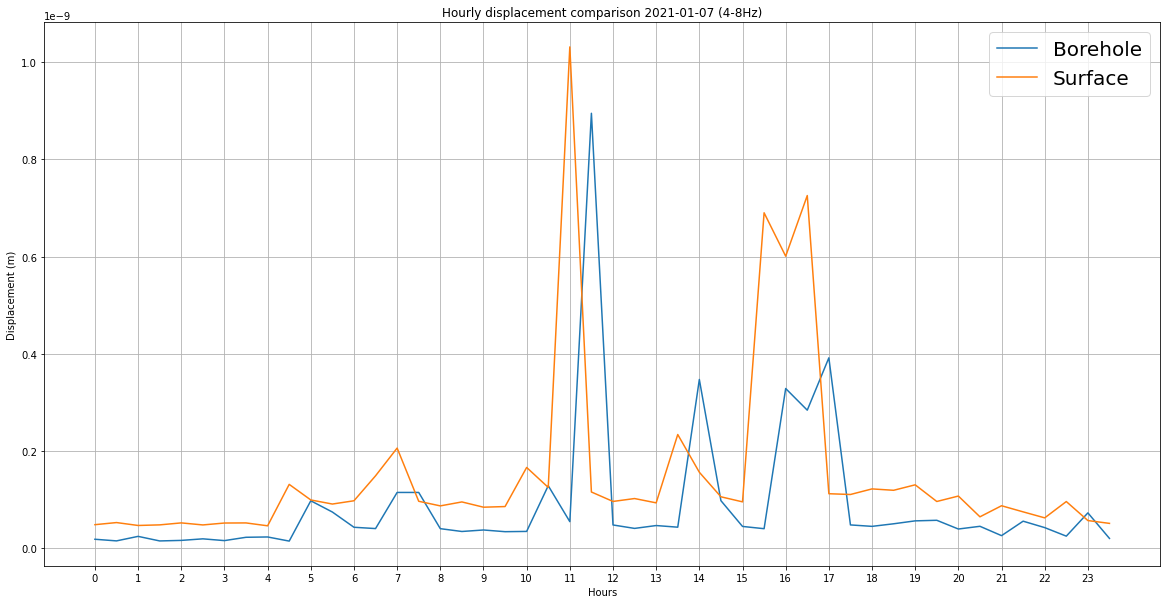

In [8]:
### Paramètres à changer
freq = "2.0-8.0"


periods = [[UTCDateTime("2021-01-10"),UTCDateTime("2021-01-11")]]

new_noise=[]

for i in st_name :

    name = "{}{}_{}".format(i, periods[0][0].strftime('%Y-%m-%d'), periods[0][1].strftime('%Y-%m-%d'))
    noise = dRMS[i][freq]
    t, h, noise_matrix = hourly_var(noise, periods)
    new_noise.append(noise_matrix.tolist()[indice:] + noise_matrix.tolist()[0:indice])

    
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams["axes.facecolor"] = 'w'
plt.title('Hourly displacement comparison 2021-01-07 (4-8Hz)')
plt.xlabel('Hours')
plt.ylabel('Displacement (m)' )
c1=('Borehole')

for i in new_noise :
    plt.plot(h,i,label=c1)
    c1=('Surface')

#plt.plot(test3,test2,color='r', linewidth=2.5,linestyle="--",label='')
plt.xticks(np.arange(0, 24, 1), np.arange(0, 24, 1))
plt.grid()
plt.legend(fontsize=20)
plt.show()

## Avec une échelle différente

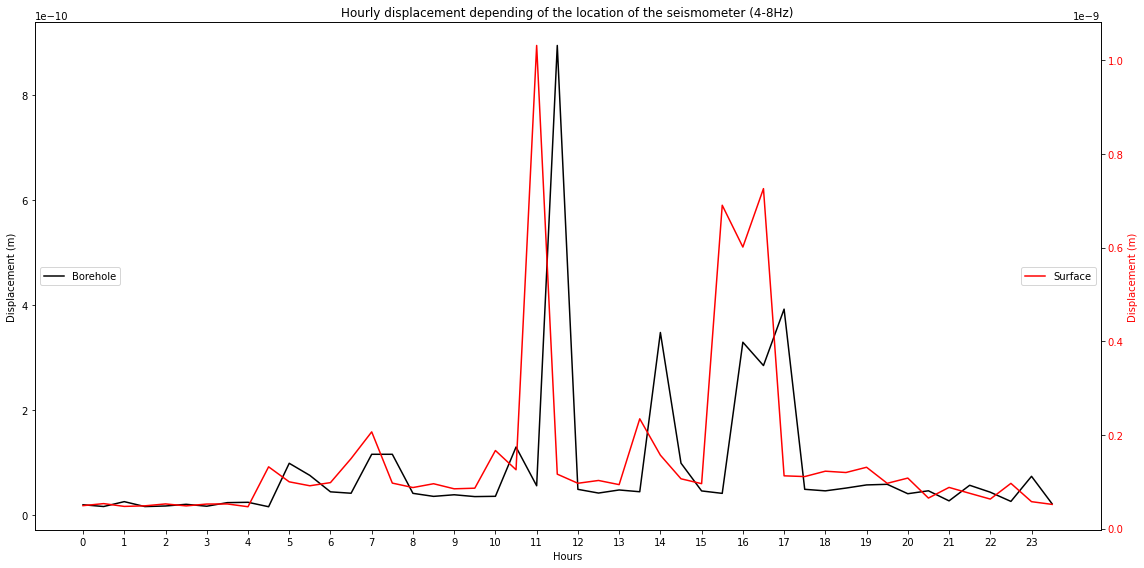

In [11]:



### Paramètres à changer
freq = "2.0-8.0"
periods = [[UTCDateTime("2021-01-10"),UTCDateTime("2021-01-11")]]
###

#Station en forage
st_name = "G.CCD.20.BHZ_2_8Hz"
name = "{}{}_{}".format(st_name, periods[0][0].strftime('%Y-%m-%d'), periods[0][1].strftime('%Y-%m-%d'))
noise = dRMS[st_name][freq]
t, h, noise_matrix = hourly_var(noise, periods)
new_noise1 = noise_matrix.tolist()[indice:] + noise_matrix.tolist()[0:indice]


#Station à la surface
st_name = "G.CCD.00.BHZ"
name = "{}{}_{}".format(st_name, periods[0][0].strftime('%Y-%m-%d'), periods[0][1].strftime('%Y-%m-%d'))
noise = dRMS[st_name][freq]
t, h, noise_matrix = hourly_var(noise, periods)
new_noise2 = noise_matrix.tolist()[indice:] + noise_matrix.tolist()[0:indice]


#PLot du graphique
plt.rcParams['figure.figsize'] = 16, 8
fig, ax1 = plt.subplots()
ax1.plot(h,new_noise1, 'k-',label='Borehole')
#ax1.plot(test,test2,color='r', linewidth=2.5,label='Lunch break')
plt.legend(loc=6)
ax1.set_ylabel('Displacement (m)',color='k')
ax2 = ax1.twinx()
ax2.plot(h,new_noise2, 'r-',label='Surface')
ax2.set_ylabel('Displacement (m)',color='r',)
plt.legend(loc=7)


for tl in ax1.get_yticklabels():
    tl.set_color('k')
for t2 in ax2.get_yticklabels():
    t2.set_color('r')
    

    

title=str('Hourly displacement depending of the location of the seismometer (4-8Hz)')
plt.title(title)
ax1.set_xlabel('Hours')
plt.xticks(np.arange(0, 24, 1), np.arange(0, 24, 1))



plt.tight_layout()
#plt.savefig('C:/Users/Arnaud/Desktop/Travail/seismic-noise/RESULTS/ant_deep_var/comp_winter_2021.png')
plt.show()
